In [1]:
import os
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import math

if not os.path.abspath('.').endswith('netscope'):
    root_path = os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath('.'))))
    os.chdir(root_path)
    from analysis.load import Loader
    from evaluation.intsight.IntSight import IntSight

markers = list('ov^<>12348sp*hH+xXDd|_.,')+[i for i in range(12)]

mpl.rcParams.update({
    'axes.spines.right': False,
    'axes.spines.top': False,
})
plt.rc('figure', figsize=[6,3.5])
plt.rc('font', family='Times New Roman', size=18)

In [2]:
# log_dir = "evaluation/overhead/data/20221003_0703GMT"
# log_dir = "evaluation/overhead/data/20221003_1422GMT"
# log_dir = "evaluation/overhead/data/20221003_1428GMT"
# log_dir = "experiment/data/slot2/burst/20221003_1445GMT"
log_dir = "evaluation/other/overhead/data/20221003_1451GMT"


In [3]:
loader = Loader(log_dir)
topo = loader.get_topo()
digests = loader.load_digest()
latencys = loader.load_latency()
hosts = loader.load_hosts(debug=True)
hosts['flow'] = hosts['src'] + '-' + hosts['dst']

IntSight_report = IntSight(hosts)

In [4]:
sw_data = []
for _, row in hosts.iterrows():
    for hop in row.debug:
        hop.update(dict(flow=row.flow))
        sw_data.append(hop)
sw_dfs = pd.DataFrame(sw_data).sort_values('timestamp')

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


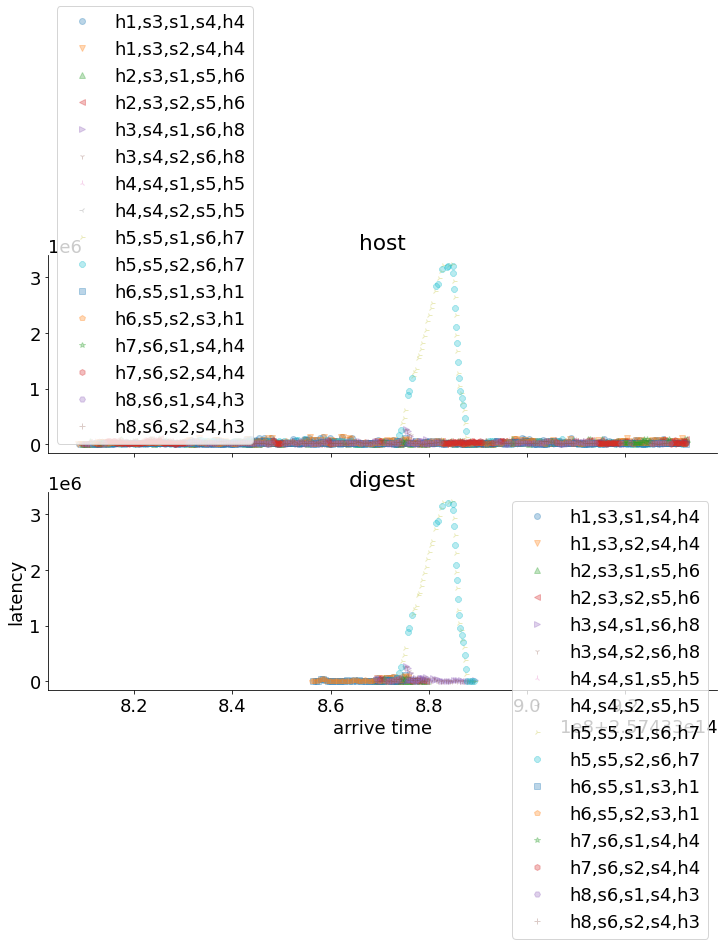

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12, 8)) 
for i, path in enumerate(sorted(hosts.whole_path.unique())):
    hosts[hosts.whole_path==path].plot('arrive_t', 'latency', ax=axes[0], label=path, alpha=0.3, lw=1, marker=markers[i], ls='')
    axes[0].set_title('host')
for i, path in enumerate(sorted(digests.whole_path.unique())):
    digests[digests.whole_path==path].plot('arrive_t', 'latency', ax=axes[1], label=path, alpha=0.3, lw=1, marker=markers[i], ls='')
    axes[1].set_title('digest')
plt.ylabel('latency');plt.xlabel('arrive time');

In [5]:
timespan = max(hosts.timestamp) - min(hosts.timestamp)
SpiderMon_epoch = 100 # ms

In [6]:
IntSight_report_L = len(IntSight_report)

In [7]:
digests_df = digests.copy(deep=True)
digests_df['sw_count'] = digests_df.path_str.str.count(',')
digest_pkt_sw_count = digests_df['sw_count'].sum()
print(digest_pkt_sw_count)

1266


In [8]:
digests_df['epoch'] = digests_df.timestamp.apply(lambda t: math.floor(t/SpiderMon_epoch))
digest_flow_sw_epoch_count = digests_df[digests_df.duplicated(['src', 'dst', 'epoch'])==False]['sw_count'].sum()
digest_flow_sw_epoch_count = int(digest_flow_sw_epoch_count * 0.7)

In [9]:
sw_epoch_flow_count = 0
for sw, sw_df in sw_dfs.groupby(['sw_id']):
    sw_df['epoch'] = sw_df.timestamp.apply(lambda t: math.floor(t/SpiderMon_epoch))
    for epoch, sdf in sw_df.groupby(['epoch']):
        sw_epoch_flow_count += len(sdf.flow.unique())

# sw_epoch_flow_count = int(sw_epoch_flow_count/10)
print("sw_epoch_flow_count", sw_epoch_flow_count)

sw_epoch_flow_count 10623


In [3]:
# NetScope
HDS_NetScope_naive = 4 # path id
HDS_NetScope_telemetry = 48 + 20 + HDS_NetScope_naive
HDS_NetScope_report = 16 + 32 + 16 + 12*3 + HDS_NetScope_telemetry
HDS_NetScope_latency = 32

# IntSight
HDS_IntSight_telemetry = 33*8
HDS_IntSight_report = 54*8

# SpiderMon
HDS_SpiderMon_naive = 32
HDS_SpiderMon_telemetry = 36*8
HDS_SpiderMon_telemetry_shim = 8 + 16 + 8
HDS_SpiderMon_pkt = 16 + 20 # queue info

# SyNDB
HDS_SyNDB_pRecord = 16 + 16 + 16 + 32 + 24
# HDS_SyNDB_trigger = 0

In [17]:
"""
print(len(digests), HDS_NetScope_report, digest_pkt_sw_count, HDS_SpiderMon_pkt)
print(len(digests) * HDS_NetScope_report, digest_pkt_sw_count * HDS_SpiderMon_pkt)

422 172 1266 36
72584 45576
"""

HDS_NetScope_report
print(len(digests), HDS_NetScope_report, digest_pkt_sw_count, HDS_SpiderMon_pkt)
print(len(digests) * HDS_NetScope_report, digest_pkt_sw_count * HDS_SpiderMon_pkt)

422 172 1266 36
72584 45576


In [12]:
print("NetScope") # NS
print("telemetry overhead:", 
      len(hosts[hosts.src_count > 1]) * HDS_NetScope_naive + 
      len(hosts[hosts.src_count == 1]) * HDS_NetScope_telemetry)
print("report overhead   :", 
      len(digests) * HDS_NetScope_report + 
      len(latencys) * HDS_NetScope_latency)


print("IntSight") # IS
print("telemetry overhead:", 
      len(hosts) * HDS_IntSight_telemetry)
print("report overhead   :", 
      IntSight_report_L * HDS_IntSight_report)


print("SpiderMon") # SM
print("telemetry overhead:", 
      len(hosts) * HDS_SpiderMon_naive)
print("report overhead   :", 
      digest_pkt_sw_count * HDS_SpiderMon_pkt + 
      sw_epoch_flow_count * HDS_SpiderMon_telemetry + 
      math.ceil(sw_epoch_flow_count / (200/36)) * HDS_SpiderMon_telemetry_shim)

print("SyNDB") # SD
print("telemetry overhead:", 
      0)
print("report overhead   :", 
      len(sw_dfs) * HDS_SyNDB_pRecord)

"""
NetScope
telemetry overhead: 185524
report overhead   : 184968
IntSight
telemetry overhead: 934824
report overhead   : 496800
SpiderMon
telemetry overhead: 113312
report overhead   : 3166216
SyNDB
telemetry overhead: 0
report overhead   : 1104792
"""


NetScope
telemetry overhead: 185524
report overhead   : 184968
IntSight
telemetry overhead: 934824
report overhead   : 496800
SpiderMon
telemetry overhead: 113312
report overhead   : 3166216
SyNDB
telemetry overhead: 0
report overhead   : 1104792


In [25]:
# print("NetScope") # NS
NS_tel = (len(hosts[hosts.src_count > 1]) * HDS_NetScope_naive + 
          len(hosts[hosts.src_count == 1]) * HDS_NetScope_telemetry)
NS_rep = (len(digests) * HDS_NetScope_report + 
          len(latencys) * HDS_NetScope_latency)

# print("IntSight") # IS
IS_tel = len(hosts) * HDS_IntSight_telemetry
IS_rep = IntSight_report_L * HDS_IntSight_report

# print("SpiderMon") # SM
SM_tel = len(hosts) * HDS_SpiderMon_naive
SM_rep = (digest_pkt_sw_count * HDS_SpiderMon_pkt + 
          digest_flow_sw_epoch_count * HDS_SpiderMon_telemetry + 
          math.ceil(digest_flow_sw_epoch_count / (200/36)) * HDS_SpiderMon_telemetry_shim + 
          # sw_epoch_flow_count * HDS_SpiderMon_telemetry + 
        #   math.ceil(sw_epoch_flow_count / (200/36)) * HDS_SpiderMon_telemetry_shim
          0)

# print("SyNDB") # SD
SD_tel = 0
SD_rep = len(sw_dfs) * HDS_SyNDB_pRecord

In [26]:
digest_pkt_sw_count * HDS_SpiderMon_pkt / SM_rep

0.0143944696129386

In [27]:
len(hosts[hosts.src_count == 1]) * HDS_NetScope_telemetry / NS_tel

0.9779866755783618

In [28]:
df = pd.DataFrame([
    dict(abbr="NS", name="NetScope", telemetry=NS_tel, report=NS_rep),
    dict(abbr="SM", name="SpiderMon", telemetry=SM_tel, report=SM_rep),
    dict(abbr="IS", name="IntSight", telemetry=IS_tel, report=IS_rep),
    dict(abbr="SN", name="SyNDB", telemetry=SD_tel, report=SD_rep),
])

KB = 1024 * 8

In [29]:
df

,abbr,name,telemetry,report
0,NS,NetScope,185524,184968
1,SM,SpiderMon,113312,3166216
2,IS,IntSight,934824,496800
3,SN,SyNDB,0,1104792


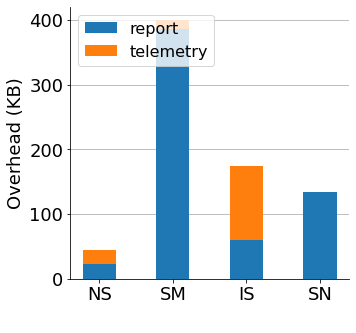

In [30]:
plt.figure(figsize=(5, 5))
bar_width = 0.45
bar_args = dict(width=bar_width, zorder=10)
tel_list = df.telemetry / KB
rep_list = df.report    / KB
plt.bar(np.arange(4), rep_list, label='report', **bar_args)
plt.bar(np.arange(4), tel_list, bottom=rep_list, label='telemetry', **bar_args)
plt.xticks(np.arange(4), df.abbr)
# plt.yticks([])
plt.ylabel('Overhead (KB)')
plt.xlabel(' ')
plt.grid(axis='y')
plt.legend(loc="upper left", prop={'size': 16}).set_zorder(20)
# plt.savefig('evaluation/other/overhead/overhead.pdf', bbox_inches = 'tight')

In [ ]:
digests

,index,src,dst,timestamp,latency,path_pkt_size,qdepth,path_count,flow_count,flow_drop,path_id,receive_t,sw,global_path_id,path,path_str,whole_path,arrive_t
0,15,h6,h1,257433874308920,22484,402,0,1,1,0,5,890778729230084,s3,s5-s3:5,"[s5, s2, s3]","s5,s2,s3,","h6,s5,s2,s3,h1",257433874331404
1,14,h6,h1,257433874061485,49969,335,0,1,1,0,1,890778729230259,s3,s5-s3:1,"[s5, s1, s3]","s5,s1,s3,","h6,s5,s1,s3,h1",257433874111454
2,13,h6,h1,257433873808981,52559,402,0,1,1,0,5,890778729230299,s3,s5-s3:5,"[s5, s2, s3]","s5,s2,s3,","h6,s5,s2,s3,h1",257433873861540
3,12,h6,h1,257433873564417,57884,335,0,1,1,0,1,890778729230344,s3,s5-s3:1,"[s5, s1, s3]","s5,s1,s3,","h6,s5,s1,s3,h1",257433873622301
4,11,h6,h1,257433873323506,22363,402,0,1,1,0,5,890778729230379,s3,s5-s3:5,"[s5, s2, s3]","s5,s2,s3,","h6,s5,s2,s3,h1",257433873345869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,64,h1,h4,257433876869297,16455,746,0,2,2,0,1,890779068355418,s4,s3-s4:1,"[s3, s1, s4]","s3,s1,s4,","h1,s3,s1,s4,h4",257433876885752
80,2,h8,h3,257433879091907,9522,909,0,2,2,0,5,890779170741336,s4,s6-s4:5,"[s6, s2, s4]","s6,s2,s4,","h8,s6,s2,s4,h3",257433879101429
81,1,h1,h4,257433879036835,13485,825,0,2,2,0,5,890779170741545,s4,s3-s4:5,"[s3, s2, s4]","s3,s2,s4,","h1,s3,s2,s4,h4",257433879050320
82,0,h8,h3,257433878843951,21971,832,0,2,2,0,1,890779170741584,s4,s6-s4:1,"[s6, s1, s4]","s6,s1,s4,","h8,s6,s1,s4,h3",257433878865922
